# Introduction:

This notebook uses [Scikit Learn](https://scikit-learn.org/stable/) to try out 3 different types of regression models to predict the price of that stock for a future date. As a former Accenture consultant many years ago I decided to use their stock price for the exercise instead of the typical popular tech companies used in many other examples. If you want to use another company just update the stock ticker symbol in the code below.

These techniques can be applied to any timeseries dataset, of which stock prices are one form of.

At the end I also try using Keras to train an deep learning model against the data with good results.

## Install Required Modules:

In [ ]:
# Make sure we have all the required modules imported into our environment

import sys
!{sys.executable} -m pip install -U pandas
!{sys.executable} -m pip install -U pandas_datareader
!{sys.executable} -m pip install -U matplotlib
!{sys.executable} -m pip install -U scikit-learn
!{sys.executable} -m pip install -U keras
!{sys.executable} -m pip install -U tensorflow

## Read Stock Data Into Pandas From Yahoo Finance:

In [112]:
# Get the historic stock price data for the past 10 years from Yahoo finance

import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2009, 1, 1)
end = datetime.datetime(2019, 9, 8)

# Get NYSE:ACCENTURE share price from Yahoo finance
df = web.DataReader("ACN", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-03,197.759995,195.440002,196.360001,195.750000,1696500.0,195.750000
2019-09-04,198.360001,197.369995,197.830002,197.710007,1250700.0,197.710007
2019-09-05,199.800003,198.449997,199.800003,199.490005,2216100.0,199.490005
2019-09-06,202.800003,199.039993,200.000000,201.119995,2184100.0,201.119995
2019-09-09,201.119995,192.839996,200.970001,194.830002,2702800.0,194.830002


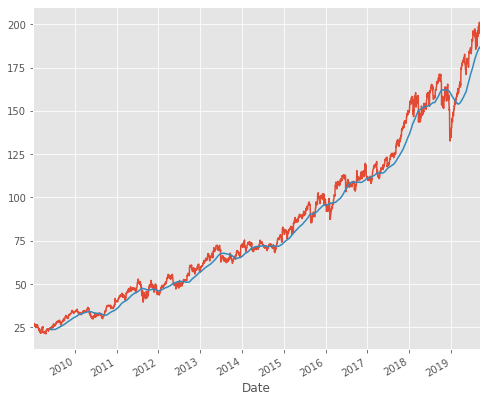

In [113]:
# Get the closing price and calculate the 100 day moving average as a new dataset:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

# Plot the actual closing price vs. the moving average
close_px.plot(label='ACN')
mavg.plot(label='mavg')
plt.show()

# Model Prediction

Now we have the data we can engineer the features we want to use to predict the stock price and train our machine learning models against them. For this exercise 3 models will be compared from Scikit:

* Simple Linear Analysis
* Quadratic Linear Analysis (QDA)
* K Nearest Neighbor (KNN)

## Feature Engineering:

For this exercise, we don't need the additional features, but this code example shows how you can create a new table with engineered features and additional columns that could be used for training more advanced models (i.e. deep learning) later on.

In [114]:
# Feature Engineering: 
# Create a new dataframe with the following features: 
# Adjusted Close, Trading Volume, High/Low Percentage, Percentage Change

dataset_full = df.loc[:,["Adj Close","Volume"]]
dataset_full["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dataset_full["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0
print(f"Full Dataset Size: {dataset_full.shape}")
dataset_full.head()

Full Dataset Size: (2689, 4)


,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2009-01-02,26.809996,3787400.0,3.742199,3.472641
2009-01-05,26.929438,4469100.0,4.228257,1.106125
2009-01-06,26.595007,4020100.0,3.413172,1.488914
2009-01-07,26.897581,5442100.0,7.430428,2.799751
2009-01-08,26.626854,3203800.0,1.375607,0.541192


## Pre-Processing The Data:

We need to make sure our training and test data is prepared so the model can train and test its results properly. As this is a time-series dataset (i.e. the Adjusted Close price changes over a time window) we need to do the following to ensure accurate results:

1. Remove any missing values, this will cause issues when we run the training model
2. Re-organise the data into our output (Y, the adjusted close price we want to predict) and input (X, the previous adjusted close prices before Y). Because this is time-series, we use a sliding window of 32 days of Adjusted Close prices (X) to predict the 33rd day's Close price (Y), so we will re-organise a new Pandas dataframe with each row having an array of 32 days of Adjusted Closing prices leading up to the last value we want to predict on day 33 (Y) as the feature we want to predict.
3. To avoid overfitting of the model to the data, we cannot use the same training data to test the model during iterations. Therefore we split the training data into 2 parts: the first 80% of the data will be used as the input training data, and the last 20% of the data will be used for testing the model. Read more at [https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6).

In [115]:
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, svm

# 1. Remove missing values
rows, width = dataset_full.shape
dataset_full.dropna(inplace=True)
nrows, nwidth  = dataset_full.shape
print(f"{rows - nrows} empty value rows removed.\n")

# 2. Re-organise data into a sliding window of 33 day time slices, with the first 32 values used to train the model
#    to predict the 33rd day. We only need one feature, the 'Adj Close' for the models to train on. The output of
#    this creates an array, not a Pandas dataframe as before

window_size = 32 # this is allowing us to look back 32 days in past

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

data = df['Adj Close'].values[indices] # Create the 2D array of training samples

print("Reorganised Dataframe into 32 day sliding windows:")
print(data.shape)
print(data)
print("\n")

# 3. Split data into train and test data sets to avoid overfitting

X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day
# Train and test split
split_fraction = 0.80
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

0 empty value rows removed.

Reorganised Dataframe into 32 day sliding windows:
(2657, 33)
[[ 26.80999565  26.92943764  26.59500694 ...  24.15050125  24.69195557
   24.53270149]
 [ 26.92943764  26.59500694  26.8975811  ...  24.69195557  24.53270149
   23.87180901]
 [ 26.59500694  26.8975811   26.62685394 ...  24.53270149  23.87180901
   23.00388527]
 ...
 [194.44000244 194.46000671 194.47000122 ... 195.75       197.71000671
  199.49000549]
 [194.46000671 194.47000122 194.97000122 ... 197.71000671 199.49000549
  201.11999512]
 [194.47000122 194.97000122 196.92999268 ... 199.49000549 201.11999512
  194.83000183]]


X_train.shape: (2125, 32)
y_train.shape: (2125,)


## Model 1: Linear Regression Model

This is the simplest model we can use. Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data.

The linear regression confidence is 98.82115395813929%


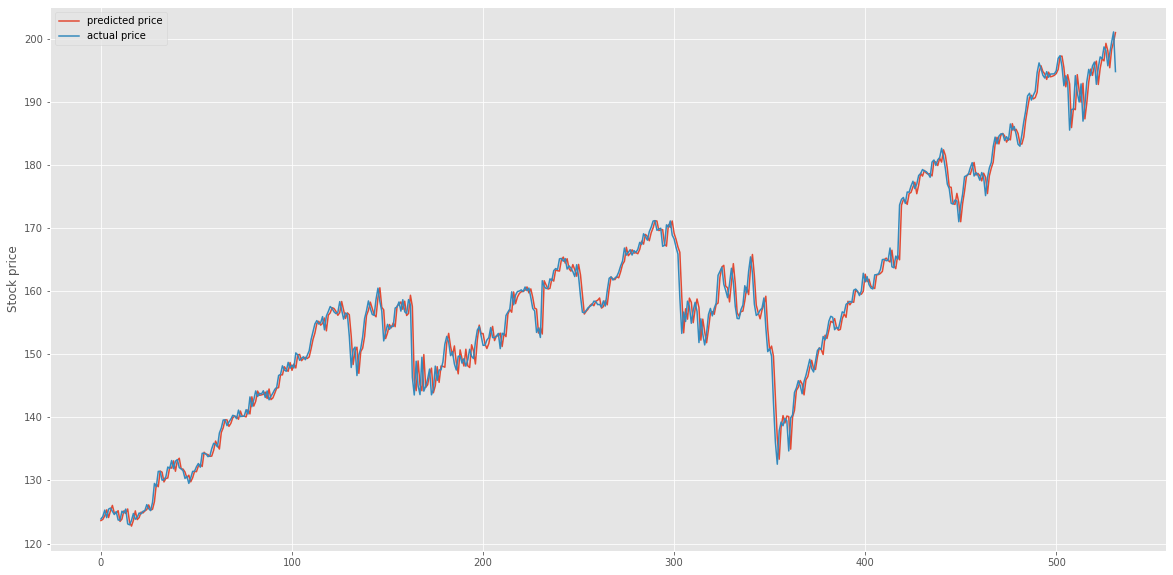

In [116]:
from sklearn.linear_model import LinearRegression

# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

confidence_lr = lr_model.score(X_test, y_test) * 100
print(f"The linear regression confidence is {confidence_lr}%")

# Make a prediction
lr_prediction = lr_model.predict(X_test)

# Plot the prediction
plt.figure(figsize=(20,10))
plt.plot(lr_prediction)
plt.plot(y_test)
plt.legend(['predicted price','actual price'])
plt.ylabel('Stock price')

plt.show()

## Model 2: Quadratic Discriminant Analysis (QDA)

Quadratic Discriminant Analysis (QDA) tried to fit a Quadratic equation curve to the data allowing for more flexibility than a simple straight (linear) line. More information can be learnt [here](https://scikit-learn.org/stable/modules/lda_qda.html).

The quadratic regression 2 confidence is 94.37339918895405%


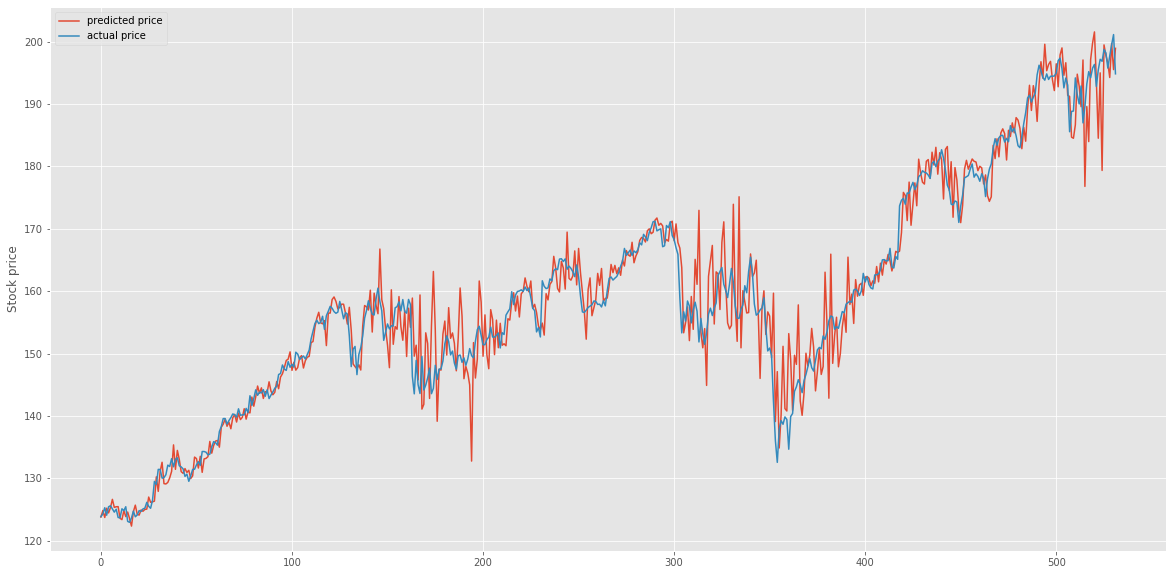

In [117]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Train the model
poly2_model = make_pipeline(PolynomialFeatures(2), Ridge())
poly2_model.fit(X_train, y_train)

confidence_poly2 = poly2_model.score(X_test,y_test) * 100
print(f"The quadratic regression 2 confidence is {confidence_poly2}%")

# Make a prediction
poly2_prediction = poly2_model.predict(X_test)

# Plot the prediction
plt.figure(figsize=(20,10))
plt.plot(poly2_prediction)
plt.plot(y_test)
plt.legend(['predicted price','actual price'])
plt.ylabel('Stock price')

plt.show()

## Model 3. Gradient Boosting Regressor

Also known as Gradient Tree Boosting, Gradient boosting is one of the most powerful techniques for building predictive models. You can learn more [here](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/).

The Gradient Boosting Regressor confidence is -362.67636245272524%


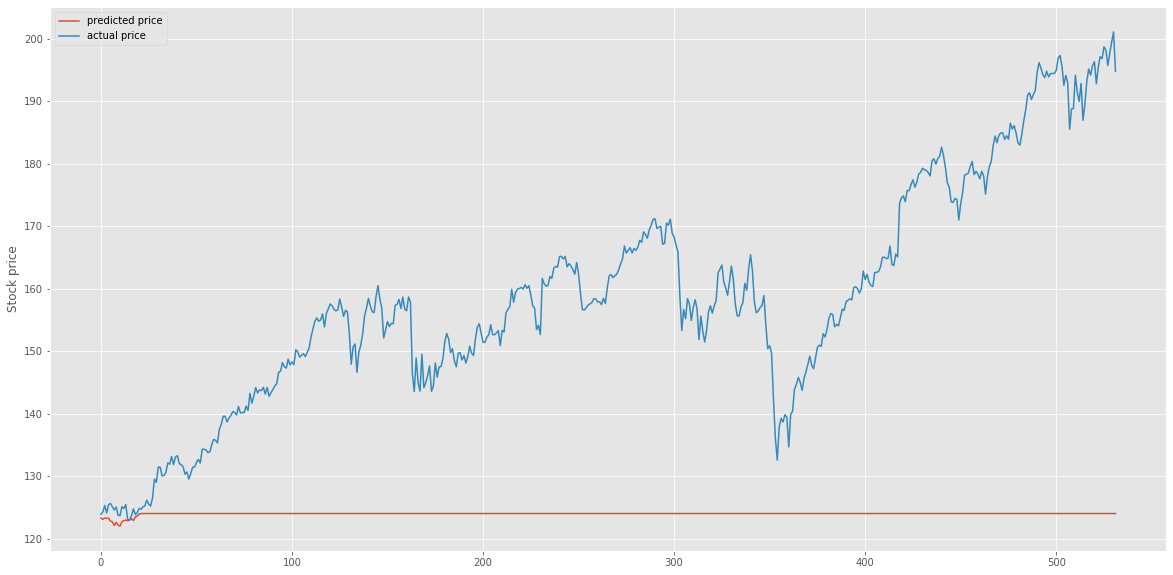

In [118]:
from sklearn.ensemble import GradientBoostingRegressor

# Train the model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

confidence_gb = gb_model.score(X_test,y_test) * 100
print(f"The Gradient Boosting Regressor confidence is {confidence_gb}%")

# Make a prediction
gb_prediction = gb_model.predict(X_test)

# Plot the prediction
plt.figure(figsize=(20,10))
plt.plot(gb_prediction)
plt.plot(y_test)
plt.legend(['predicted price','actual price'])
plt.ylabel('Stock price')

plt.show()

## Bonus Model: Deep Learning

In [119]:
from keras import Sequential
from keras.layers import Dense,Dropout
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=128, input_dim=32))
    regressor.add(Dense(units=64))
    regressor.add(Dense(units=32))
    regressor.add(Dense(units=16))
    regressor.add(Dense(units=8))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error',)
    return regressor

from keras.wrappers.scikit_learn import KerasRegressor
regressor = KerasRegressor(build_fn=build_regressor, batch_size=1024,epochs=1000)

# Train the model
results=regressor.fit(X_train,y_train)

Epoch 1/1000
2125/2125 [==============================] - 0s 163us/step - loss: 9370.9190
Epoch 2/1000
2125/2125 [==============================] - 0s 12us/step - loss: 7797.6894
Epoch 3/1000
2125/2125 [==============================] - 0s 11us/step - loss: 732.5414
Epoch 4/1000
2125/2125 [==============================] - 0s 16us/step - loss: 3348.9291
Epoch 5/1000
2125/2125 [==============================] - 0s 11us/step - loss: 161.7850
Epoch 6/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1619.9649
Epoch 7/1000
2125/2125 [==============================] - 0s 11us/step - loss: 619.6430
Epoch 8/1000
2125/2125 [==============================] - 0s 10us/step - loss: 232.6811
Epoch 9/1000
2125/2125 [==============================] - 0s 11us/step - loss: 662.2646
Epoch 10/1000
2125/2125 [==============================] - 0s 11us/step - loss: 66.1648
Epoch 11/1000
2125/2125 [==============================] - 0s 11us/step - loss: 214.3227
Epoch 12/1000
2125/2125 [=

2125/2125 [==============================] - 0s 11us/step - loss: 2.9703
Epoch 188/1000
2125/2125 [==============================] - 0s 12us/step - loss: 2.9618
Epoch 189/1000
2125/2125 [==============================] - 0s 11us/step - loss: 2.9400
Epoch 190/1000
2125/2125 [==============================] - 0s 13us/step - loss: 2.9399
Epoch 191/1000
2125/2125 [==============================] - 0s 27us/step - loss: 2.9266
Epoch 192/1000
2125/2125 [==============================] - 0s 12us/step - loss: 2.9188
Epoch 193/1000
2125/2125 [==============================] - 0s 11us/step - loss: 2.8815
Epoch 194/1000
2125/2125 [==============================] - 0s 12us/step - loss: 2.8948
Epoch 195/1000
2125/2125 [==============================] - 0s 11us/step - loss: 2.8754
Epoch 196/1000
2125/2125 [==============================] - 0s 11us/step - loss: 2.8427
Epoch 197/1000
2125/2125 [==============================] - 0s 12us/step - loss: 2.8456
Epoch 198/1000
2125/2125 [=====================

2125/2125 [==============================] - 0s 11us/step - loss: 2.0819
Epoch 374/1000
2125/2125 [==============================] - 0s 11us/step - loss: 2.0282
Epoch 375/1000
2125/2125 [==============================] - 0s 10us/step - loss: 2.0327
Epoch 376/1000
2125/2125 [==============================] - 0s 11us/step - loss: 2.0579
Epoch 377/1000
2125/2125 [==============================] - 0s 8us/step - loss: 1.9985
Epoch 378/1000
2125/2125 [==============================] - 0s 10us/step - loss: 1.9862
Epoch 379/1000
2125/2125 [==============================] - 0s 10us/step - loss: 2.0097
Epoch 380/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.9808
Epoch 381/1000
2125/2125 [==============================] - 0s 10us/step - loss: 2.1604
Epoch 382/1000
2125/2125 [==============================] - 0s 9us/step - loss: 2.0987
Epoch 383/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.9946
Epoch 384/1000
2125/2125 [=======================

2125/2125 [==============================] - 0s 10us/step - loss: 1.5845
Epoch 560/1000
2125/2125 [==============================] - 0s 14us/step - loss: 1.7687
Epoch 561/1000
2125/2125 [==============================] - 0s 13us/step - loss: 1.6129
Epoch 562/1000
2125/2125 [==============================] - 0s 12us/step - loss: 1.5868
Epoch 563/1000
2125/2125 [==============================] - 0s 12us/step - loss: 1.7317
Epoch 564/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.8208
Epoch 565/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.8606
Epoch 566/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.6534
Epoch 567/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.8762
Epoch 568/1000
2125/2125 [==============================] - 0s 10us/step - loss: 1.8756
Epoch 569/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.6676
Epoch 570/1000
2125/2125 [=====================

2125/2125 [==============================] - 0s 11us/step - loss: 1.4069
Epoch 746/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.7289
Epoch 747/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.5130
Epoch 748/1000
2125/2125 [==============================] - 0s 10us/step - loss: 1.6112
Epoch 749/1000
2125/2125 [==============================] - 0s 12us/step - loss: 1.6131
Epoch 750/1000
2125/2125 [==============================] - 0s 12us/step - loss: 2.3488
Epoch 751/1000
2125/2125 [==============================] - 0s 10us/step - loss: 2.2140
Epoch 752/1000
2125/2125 [==============================] - 0s 10us/step - loss: 1.8100
Epoch 753/1000
2125/2125 [==============================] - 0s 10us/step - loss: 1.8808
Epoch 754/1000
2125/2125 [==============================] - 0s 13us/step - loss: 2.5008
Epoch 755/1000
2125/2125 [==============================] - 0s 11us/step - loss: 2.5311
Epoch 756/1000
2125/2125 [=====================

2125/2125 [==============================] - 0s 11us/step - loss: 1.6622
Epoch 932/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.3811
Epoch 933/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.1470
Epoch 934/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.2369
Epoch 935/1000
2125/2125 [==============================] - 0s 10us/step - loss: 1.5453
Epoch 936/1000
2125/2125 [==============================] - 0s 12us/step - loss: 1.3936
Epoch 937/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.8004
Epoch 938/1000
2125/2125 [==============================] - 0s 11us/step - loss: 2.4728
Epoch 939/1000
2125/2125 [==============================] - 0s 11us/step - loss: 1.6649
Epoch 940/1000
2125/2125 [==============================] - 0s 12us/step - loss: 1.7630
Epoch 941/1000
2125/2125 [==============================] - 0s 13us/step - loss: 2.3822
Epoch 942/1000
2125/2125 [=====================

532/532 [==============================] - 0s 336us/step
The Deep Learning Regressor confidence is -553.5332202911377%


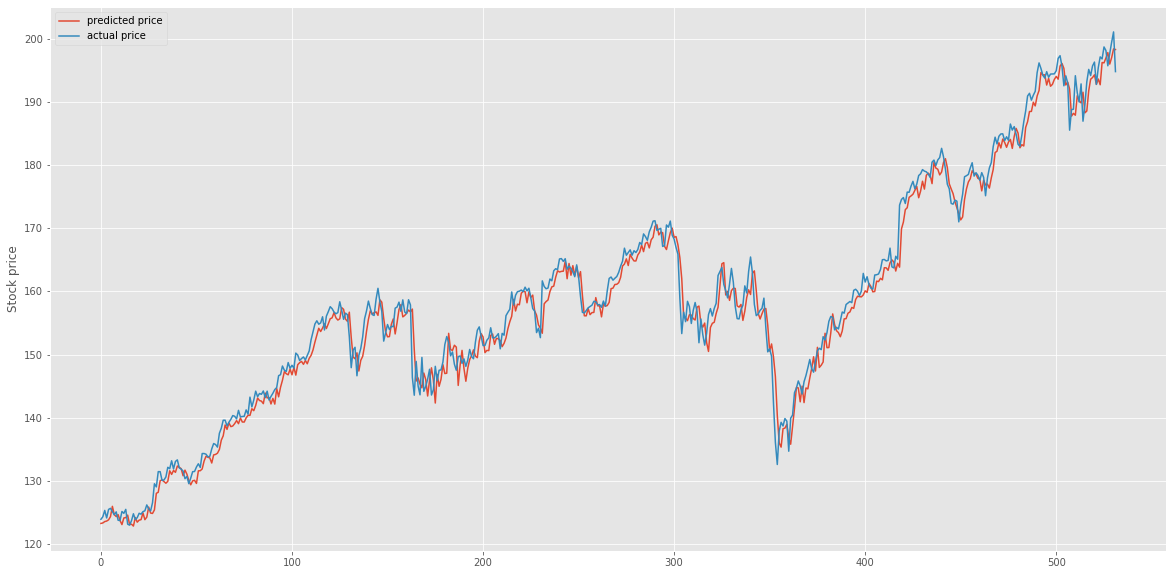

In [120]:
confidence_dl = regressor.score(X_test,y_test) * 100
print(f"The Deep Learning Regressor confidence is {confidence_dl}%")

# Make a prediction
dl_prediction = regressor.predict(X_test)

# Plot the prediction
plt.figure(figsize=(20,10))
plt.plot(dl_prediction)
plt.plot(y_test)
plt.legend(['predicted price','actual price'])
plt.ylabel('Stock price')

plt.show()

# Conclusion

1. The Linear Regression performed best, which is suprising as it is the simplest model we tried.
2. Gradient Boosting Regressors appear to be bad for this type of data. We may be able to improve the results by tuning the parameters during training.
3. Deep Learning also showed great results once the training epoch was increased to 1000 iterations
4. Need to find a better way to score the deep learning model, as the number produced doesn't look correct

In future, we should apply more features to the data set such as technical trading data, sentiment analysis of news sources and other relavent data, to give more accurate predictions in our models.